In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [24]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

#         (0, 1),
#         (1, 2),
        
#         (2, 1),
#         (2, 3),
        
#         (3, 2),
#         (3, 0),

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
        # (3, 4),
        # (4, 3)
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

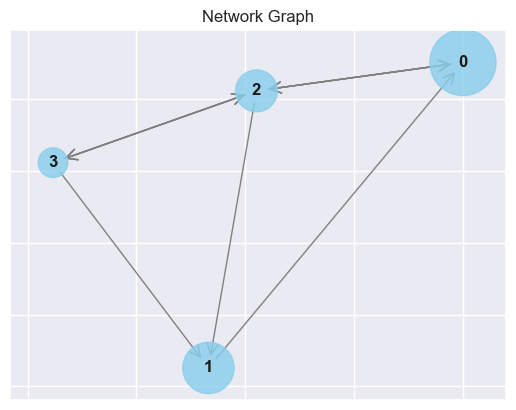

In [25]:
env = init_env()
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


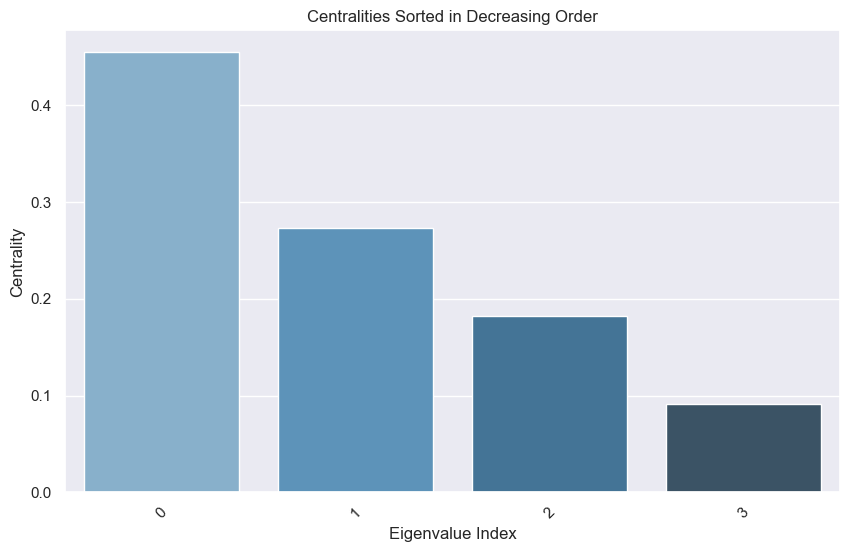

In [26]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5204647904080085
Final Error: 0.5120701748735514


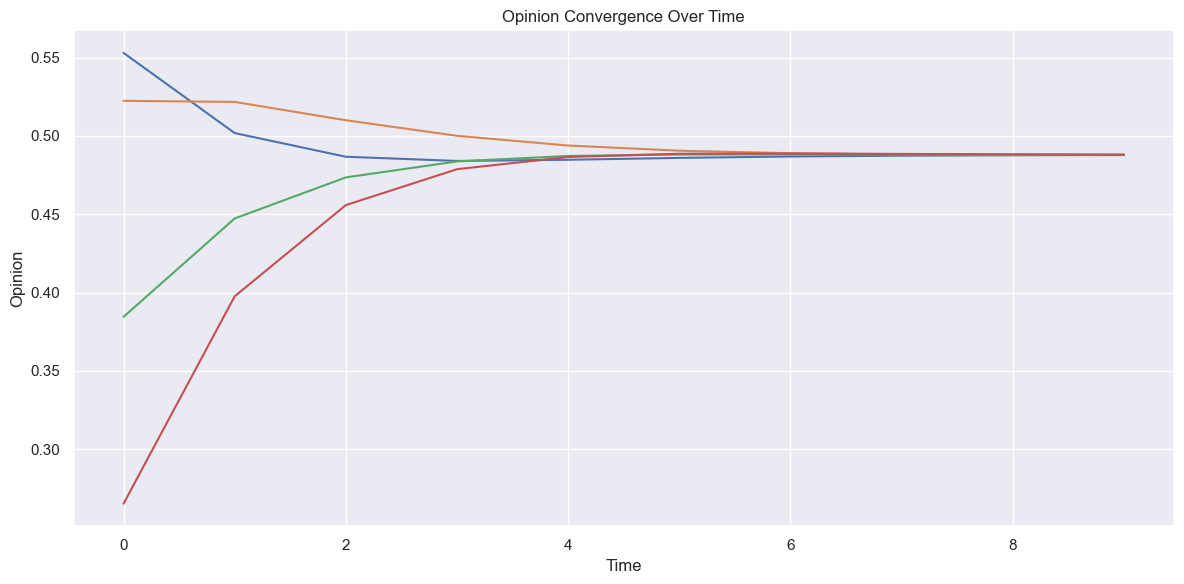

In [27]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4404062183365226
Final Error: 0.4096100799532245


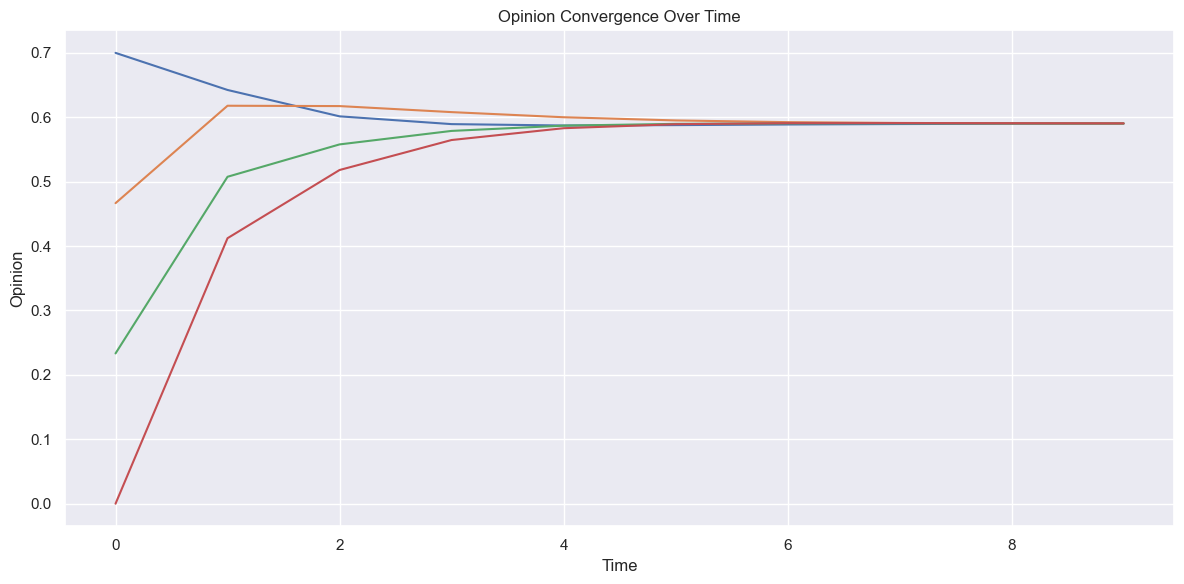

In [28]:
env = init_env()
num_steps = 10  # Total number of steps in the simulation
Q = 4  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Correct DP

DPMULT step 1
Optimal Budget Allocation (BETA): [2 2]
Final Cost: 0.38894765840220413


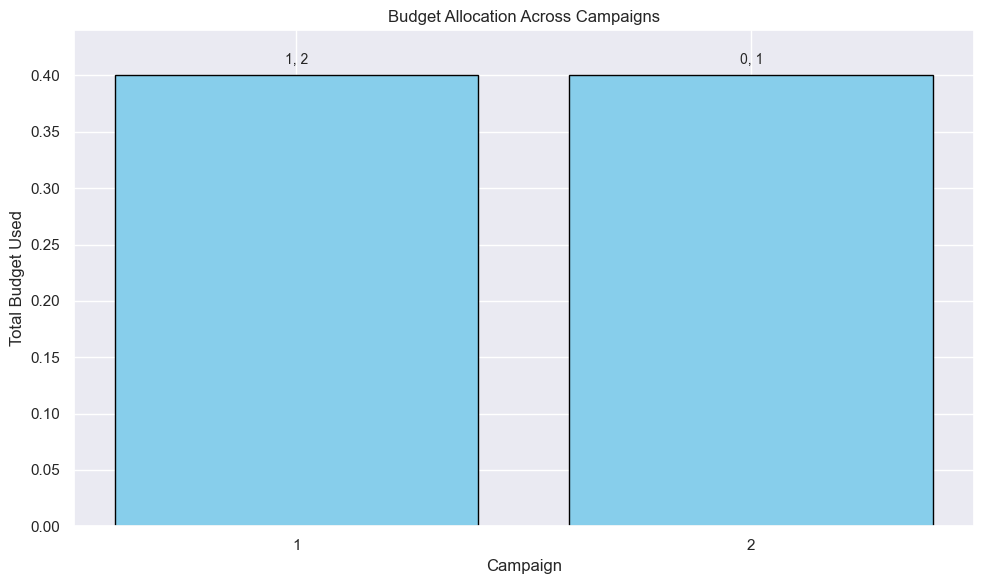

In [29]:
# Initialize environment
env = init_env()

# Parameters
M = 2  # Number of campaigns
TB = 4  # Total budget
ubar = env.max_u

# Run dynamic programming
V, B, order, order0 = dynamic_programming_multiplicative(env, M, TB)

# Forward propagation to compute optimal budget allocation and final cost
BETA, U, X, final_cost = forward_propagation_multiplicative(env, V, B, order, order0, M, TB)

# Print results
print("Optimal Budget Allocation (BETA):", BETA)
print("Final Cost:", final_cost)

plot_campaign_budgets_with_order(BETA, order, order0, ubar)

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


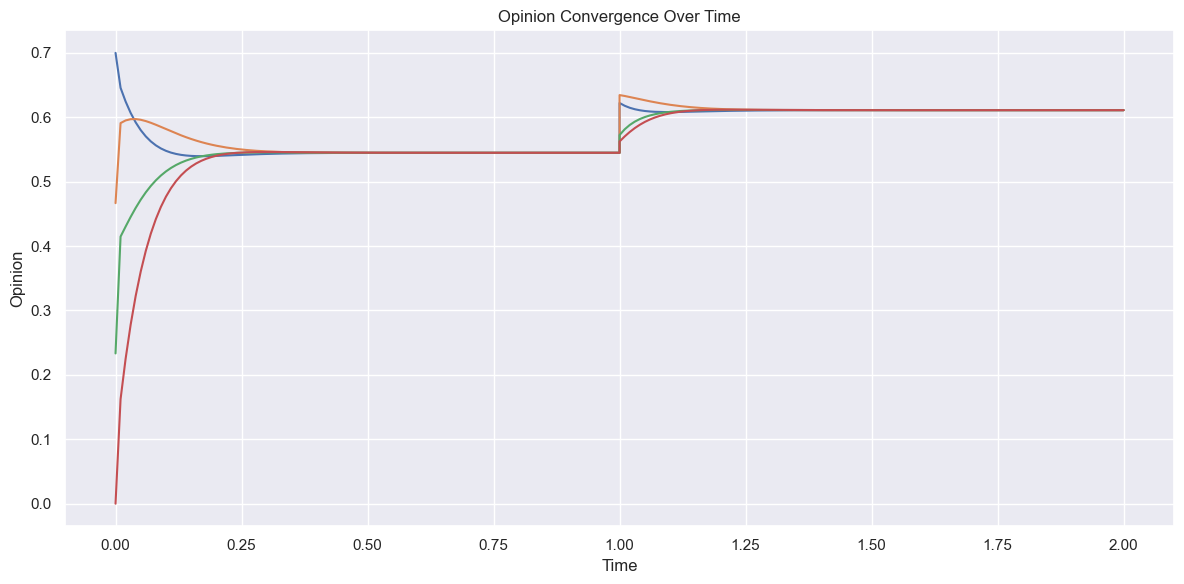

In [30]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Fine DP

In [62]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def dynamic_programming_high_dim(env, M, TB, nx=10, epsilon=1e-8):
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion
    eigv = env.centralities

    # Agent orderings based on centralities
    order = np.argsort(eigv)[::-1]  # Descending order of centralities

    # Define grid range and create an N-dimensional state grid
    grid_range = np.linspace(0, 1, nx)
    grid_shape = tuple([nx] * N)
    grid_points = np.meshgrid(*[grid_range] * N, indexing='ij')

    # Initialize value function and policy table
    V = np.full((M + 1,) + grid_shape + (TB + 1,), np.inf)
    B = np.full((M + 1,) + grid_shape + (TB + 1,), np.nan)

    # Compute terminal cost for all states
    grid_points_array = np.array(grid_points)  # Shape: (N, nx, nx, ..., nx)

    # Expand eigv to match the dimensions of grid_points_array
    eigv_expanded = eigv.reshape((N,) + (1,) * (grid_points_array.ndim - 1))  # Shape: (N,1,1,...)

    # Compute the cost as the weighted sum of squared deviations
    terminal_cost = np.sum(eigv_expanded * (grid_points_array - xd)**2, axis=0)  # Shape: grid_shape

    # Assign terminal cost to V at stage M for all remaining budget levels
    for rem in range(TB + 1):
        V[M, ..., rem] = terminal_cost

    # Backward induction from stage M-1 to stage 0
    for k in range(M - 1, -1, -1):
        print(f"DP step {k}")
        for idx in np.ndindex(grid_shape):
            current_states = np.array([grid_points[i][idx] for i in range(N)])
            for rem in range(TB + 1):
                val = np.inf
                beta_found = False
                for beta in range(0, min(rem, N) + 1):
                    control_input = np.zeros(N)
                    control_input[order[:beta]] = ubar

                    # Update the states using the same equation as in your working code
                    new_states = eigv * (control_input * xd + (1 - control_input) * current_states)
                    new_states_clipped = np.clip(new_states, grid_range[0], grid_range[-1])

                    # Prepare interpolator for V at next stage
                    interpolator = RegularGridInterpolator(
                        [grid_range] * N,
                        V[k + 1, ..., rem - beta],
                        bounds_error=False,
                        fill_value=np.inf
                    )
                    vplus = interpolator(new_states_clipped)
                    vplus = float(vplus)  # Ensure vplus is a scalar

                    # Immediate cost: sum of weighted squared deviations
                    immediate_cost = np.sum(eigv * (new_states_clipped - xd)**2)
                    total_cost = immediate_cost + vplus

                    if np.isfinite(total_cost) and total_cost < val:
                        val = total_cost
                        B[(k,) + idx + (rem,)] = beta
                        beta_found = True

                if not beta_found:
                    B[(k,) + idx + (rem,)] = 0

                V[(k,) + idx + (rem,)] = val

    return V, B, order

def forward_propagation_high_dim(env, V, B, order, M, TB, nx=10):
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion
    eigv = env.centralities

    grid_range = np.linspace(0, 1, nx)
    X = np.zeros((N, M + 1))
    BETA = np.zeros(M, dtype=int)
    U = np.zeros((N, M))
    X[:, 0] = env.opinions.copy()
    rem = TB

    for k in range(M):
        current_states = X[:, k]
        # Find the closest grid index for each state
        idx = np.searchsorted(grid_range, current_states) - 1
        idx = np.clip(idx, 0, nx - 1)
        idx = tuple(int(i) for i in idx)

        # Retrieve `beta_k` from B using correct indexing
        beta_k = B[(k,) + idx + (rem,)]
        beta_k = float(beta_k)  # Ensure beta_k is a scalar

        if np.isnan(beta_k):
            beta_k = 0
        BETA[k] = int(beta_k)

        # Apply control to the agents in the specified order
        ustar = np.zeros(N)
        ustar[order[:BETA[k]]] = ubar
        U[:, k] = ustar

         # Update the opinions with influence and network dynamics
        X[:, k + 1] = eigv * (ustar * xd + (1 - ustar) * X[:, k])

        # Ensure X values remain within [0, 1]
        X[:, k + 1] = np.clip(X[:, k + 1], 0, 1)

        rem -= BETA[k]

    # Calculate the final error based on the discrepancy from the desired opinion
    final_error = np.abs(np.mean(X[:, -1]) - xd)
    return BETA, U, X, final_error

env = init_env()  # Replace with your environment initialization
M = 2
TB = 4
nx = 5  # Consider reducing nx for testing

# Run Dynamic Programming with high-dimensional grid
V, B, order = dynamic_programming_high_dim(env, M, TB, nx=nx)

BETA, U, X, final_error = forward_propagation_high_dim(env, V, B, order, M, TB, nx=nx)

# Print results
print("Optimal Budget Allocation (BETA):", BETA)
print("Final Error:", final_error)

DP step 1


C:\Users\Chainsword\AppData\Local\Temp\ipykernel_3176\3201463173.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vplus = float(vplus)  # Ensure vplus is a scalar


DP step 0
Optimal Budget Allocation (BETA): [2 2]
Final Error: 0.9217741046831956


In [ ]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution(
        optimal_budget_allocation, env, M, step_duration
    )
)


final_opinion_error

0.3467026485114957

Dynamic Programming Strategy - Overall Error: 0.39220907286682305
Final Error: 0.34670405785587366
[array([ 0,  1,  2,  3, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13], dtype=int64), array([ 2, 10], dtype=int64)]


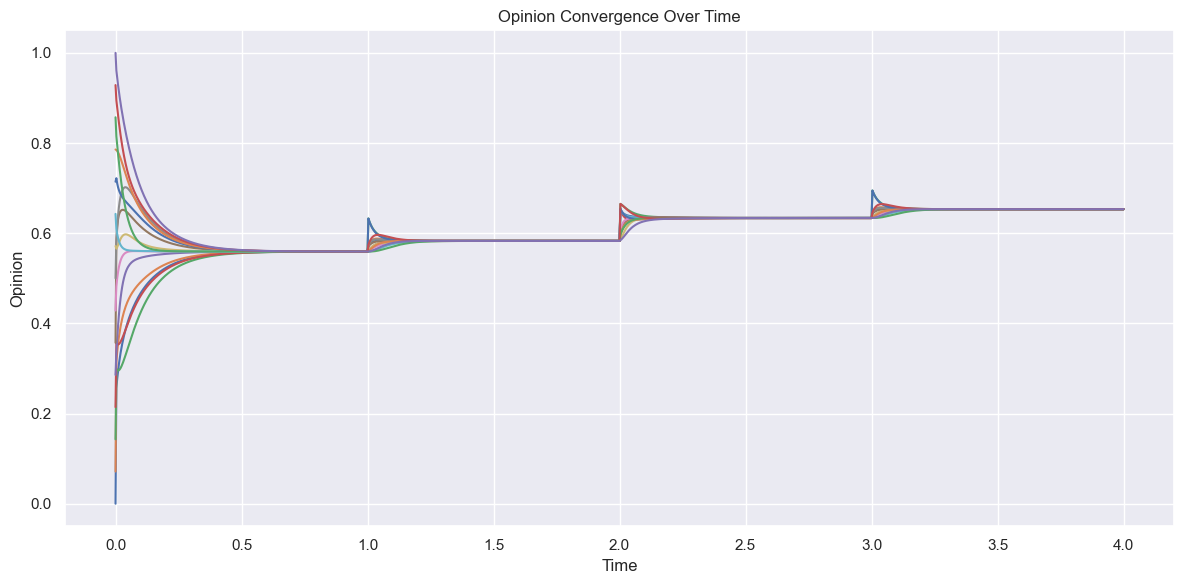

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        optimal_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [ ]:
### Brute force search

from itertools import product
from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
from viz import plot_opinions_over_time
from tqdm import tqdm

# Define parameters
total_budget = 4
num_campaigns = 2  # Number of campaigns
step_duration = 10
final_campaign_step_duration = 10  # Longer duration for the final campaign
sampling_time = 0.1
final_campaign_sampling_time = 0.1

# Initialize environment
env = init_env()

# Function to generate all valid budget allocations
def generate_valid_budget_allocations(total_budget, num_campaigns):
    """Generate all budget combinations where the sum of budgets is <= total_budget."""
    allocations = []
    for allocation in product(range(total_budget + 1), repeat=num_campaigns):
        if sum(allocation) <= total_budget:
            allocations.append(allocation)
    return allocations

# Get all valid budget allocations
valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# Store all results: budget combination and corresponding final error
results = []

# Brute-force search over all budget allocations
for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
    # Reset environment for each test
    env = init_env()

    # Run the campaigns using the current budget allocation
    opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
        env,
        budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )

    # Compute final error
    final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

    # Store the result as a tuple of (budget_allocation, final_error)
    results.append((budget_allocation, final_error))

# Sort results by final error (ascending)
results_sorted_by_error = sorted(results, key=lambda x: x[1])

# Function to display top N budget combinations
def show_top_n_budget_combinations(results_sorted, top_n=5):
    print(f"Top {top_n} Budget Combinations by Final Error:")
    for i in range(min(top_n, len(results_sorted))):
        budget_allocation, final_error = results_sorted[i]
        print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# Display the top N budget combinations
show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

Running Campaigns: 100%|██████████| 15/15 [00:00<00:00, 62.05it/s]

Top 5 Budget Combinations by Final Error:
Rank 1: Budget: (2, 2), Final Error: 0.3947194042429471
Rank 2: Budget: (3, 1), Final Error: 0.3976204174300107
Rank 3: Budget: (1, 3), Final Error: 0.3993355955383551
Rank 4: Budget: (0, 4), Final Error: 0.4117431244854009
Rank 5: Budget: (1, 2), Final Error: 0.41530338062747907


In [ ]:
# results_sorted_by_error